## Import Necessary Functions

These are required to utilise functions specific for visualisations and perform machine learning.

In [86]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [87]:
import pickle

#Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [88]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

Load the different splits

In [89]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

## Standard Random Forest Classification
First we will train and test our model on the 4 different training splits and compute some metrics. We can then apply some parameter refining to optimise how the model performs on customer churn data.

In [90]:
from sklearn.ensemble import RandomForestClassifier 
#Create initial model 
model = RandomForestClassifier(random_state=6) #Use default parameters for now

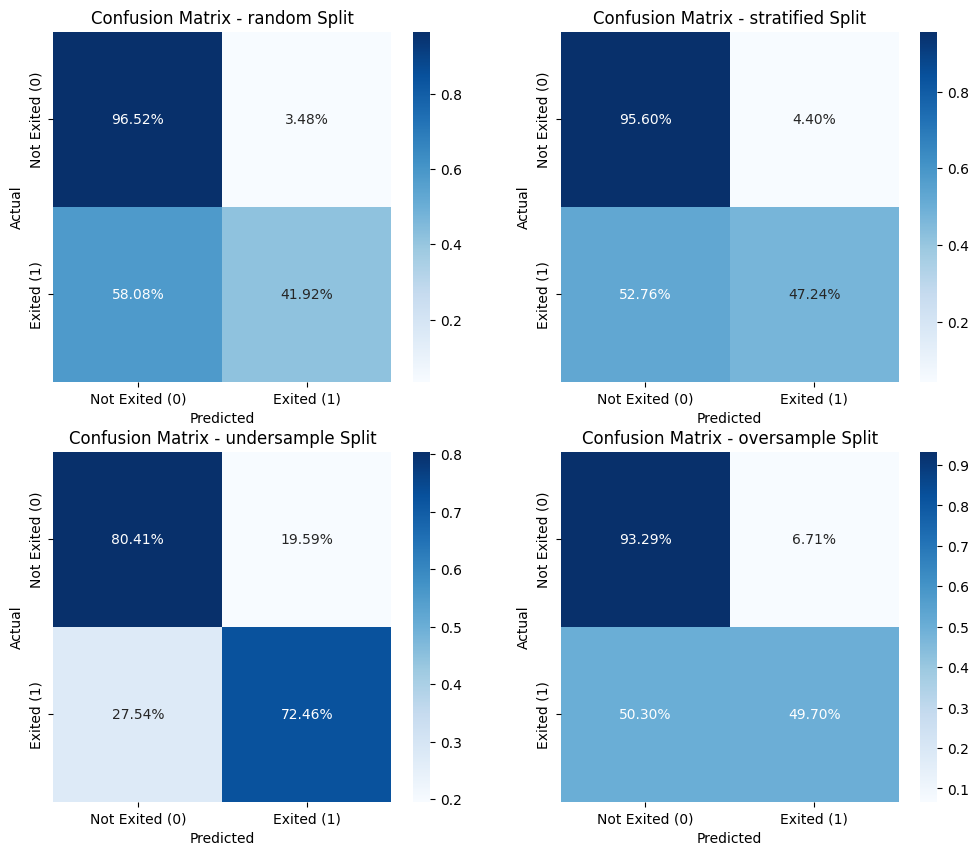

<Figure size 800x600 with 0 Axes>

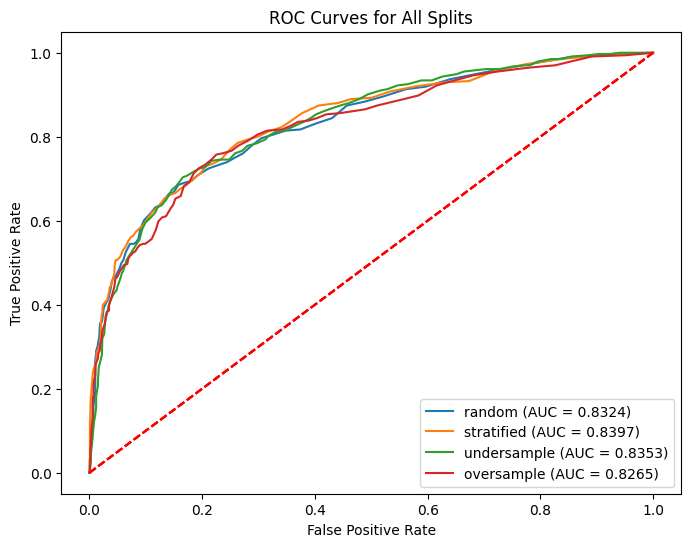

In [152]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score


#Store our performance results in a dictionary
performance = {}

def evaluating_performance_diff_splits(feature_importances, model=model,split_data=split_data,performance_matrix=performance):

    #Create a 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC curve figure 
    plt.figure(figsize=(8,6))


    #Train and evaluate the model on each split
    for i, split in enumerate(split_data):
        
        X_train, X_val, y_train, y_val = split_data[split]

        if feature_importances!=[]:
            important_feature_names = [feature[0] for feature in feature_importances[0:9]]
            print(important_feature_names)
            # Create training and testing sets with only the important features
            X_train = X_train[important_feature_names]
            X_val = X_val[important_feature_names]


        #Train the model
        model.fit(X_train, y_train)

        #Predict on validation set 
        y_val_pred = model.predict(X_val)
       

        #Get predicted probabilities that the validation observations belong to a class    
        y_score = model.predict_proba(X_val)[:, 1]  

        #Plot ROC curve on the same figure for all splits
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')


        #Plot the confusion matrix for the validation set 
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel() #Extracts raw counts from the confusion matrix 
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Normalize the confusion matrix by the number of true samples per class
        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i], #Plot confusion matrix
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[i].set_title(f'Confusion Matrix - {split} Split')
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')


        #Generate classification report
        report = classification_report(y_val, y_val_pred,output_dict = True)

        #Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)

        #Define performance metrics
        performance_matrix[split] = {
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1-score': report['1']['f1-score'],
            'support': report['1']['support'],
            'roc_auc': roc_auc,
            'balanced_accuracy': balanced_acc
        }


        #Finish off ROC curves
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for All Splits')
        plt.legend(loc='lower right')


    #Show the plots
    plt.show()  
    return performance_matrix


performance = evaluating_performance_diff_splits(feature_importances=[],model=model,split_data=split_data,performance_matrix=performance)
    

- **Random**: The model works well at correctly predicting customers who stay but only accurately identifies 42% of the customers who leave. 
- **Stratified**: We see a slighlty better performance in correctly predicting churn at 48%, but this comes at the cost of accurately identifying the non-churners.
- **Undersample**: The undersample split significantly improves the detection of the churned customers with a TP rate of 73.05%, but it comes at the cost of a worse performance for predicting the non-churners, where only 80.33% are correctly predicted.
- **Oversampled**: The oversampled split results in a similar performance to the stratified split. The balance between the two classes is better than the random split, but still not as strong as the undersampling approach for detecting Exited customers.

The ROC curve presents the trade-off between the True Positive rate and the False Positive rate across different thresholds for predicting the positive class (churn). We see that the model performs reasonably well across all ths splits. Most notabley, the Undersample split has the lowest AUC at 0.8306 even though it correctly predicts the most churned customers. We understand that a higher recall is more important because it is more costly to lose a customer than offer incentives to customers who weren't planning on leaving, hence we seek to minimise false negatives. False negatives is where the model has incorrectly predicted that a customer has not left not exist, when in reality they have. We seek to minimise this since our objective is to gauge a better understanding of the variables that lead to a customer leaving.

In [92]:
performance_df = pd.DataFrame(performance).T

In [93]:
performance_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.760870,0.419162,0.540541,334.0,0.832439,0.692203
stratified,0.733333,0.472393,0.574627,326.0,0.839679,0.714218
undersample,0.493878,0.724551,0.587379,334.0,0.835271,0.764329
oversample,0.661355,0.497006,0.567521,334.0,0.826450,0.714933


From the performance metrics, we can infer that the stratified split performs best overall. Having a good balance between precision (0.726), recall (0.481), and the highest AUC (0.8438), makes it the most reliable in distinguishing between classes. The undersample split achieves the best recall (0.730) and the highest balanced accuracy (0.766), but at the cost of lower precision (0.494). However, since maximising recall is more critical for correctly predicting the positive class, which is more important for building a generalizable model for the bank, the undersample split might be more suitable. Additionally, having the largest balanced accuracy is influential because it ensures the model performs well on both the majority (not-exited) and minority (exited) classes, which is especially important for our imbalanced dataset, avoiding bias towards the majority class.

## Parameter Tuning 
We perform Random Search Cross Validation for hyperparameter tuning and improve on the current Random Forest model.

In [94]:
#look at the parameters used by our current forest
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}

There are quite a lot of parameters so we read the documentation on the random forest in SK-Learn. This tells us that the number of trees in the forest (n_estimators) and the number of features considered at each leaf node (max_features) are the most important things to consider. The most efficient way to determine the best value for these and more is to just try out a wide range of values and see what performs best.
We will try adjust the following parameters:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

### Hyperparameter grid

In [95]:
#We first need to create a parameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in range(200, 1000, 200)]

# Number of features to consider at every split
max_features = ['log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid


{'n_estimators': [200, 400, 600, 800],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

The benefit of random search is that we are not trialing every combination of parameters here, which would be computationally inefficient. Instead, the algorithm selects a combination at random to sample a wide range of values. 

### Random Search Training

In [130]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
X_train, X_val, y_train, y_val = split_data['random']

#Search across 100 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=6, n_jobs = -1)

#Fit the random search model
random_search.fit(X_train, y_train)

#Print the best paremters and the best recall score
print("Best parameters found:", random_search.best_params_)
print("Best recall score", random_search.best_score_)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

### Evaluate Random Search
To determine if the random search does in fact build a better model, we compare the standard model with the best random search model.

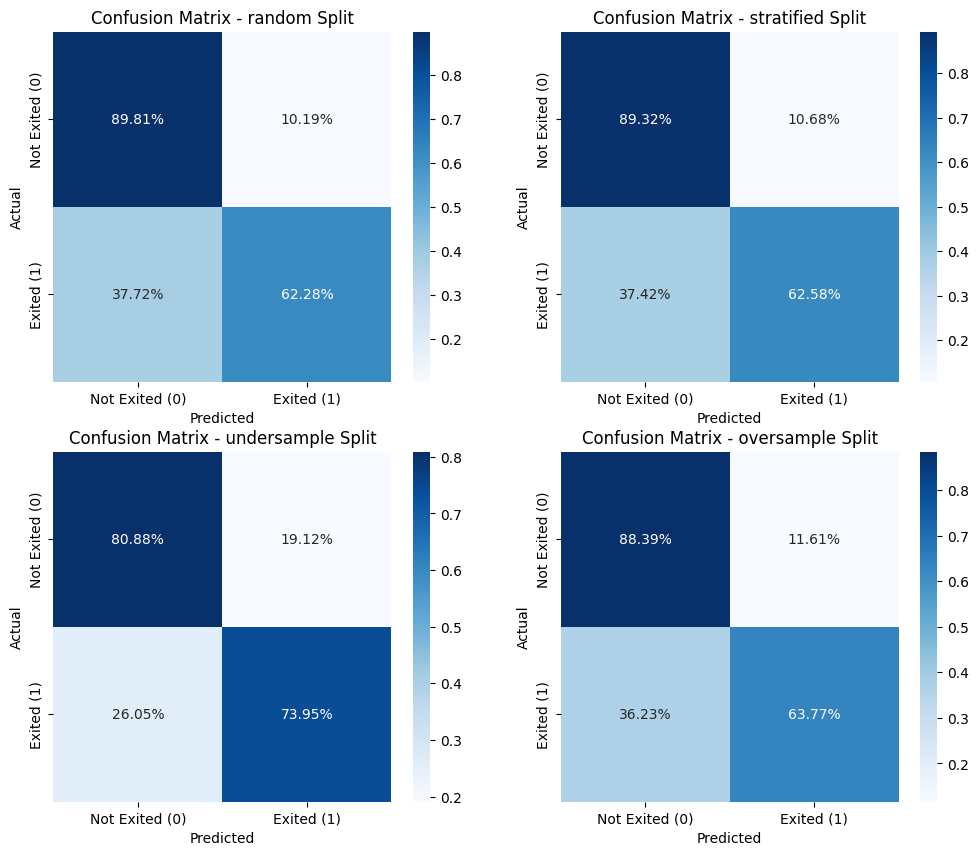

<Figure size 800x600 with 0 Axes>

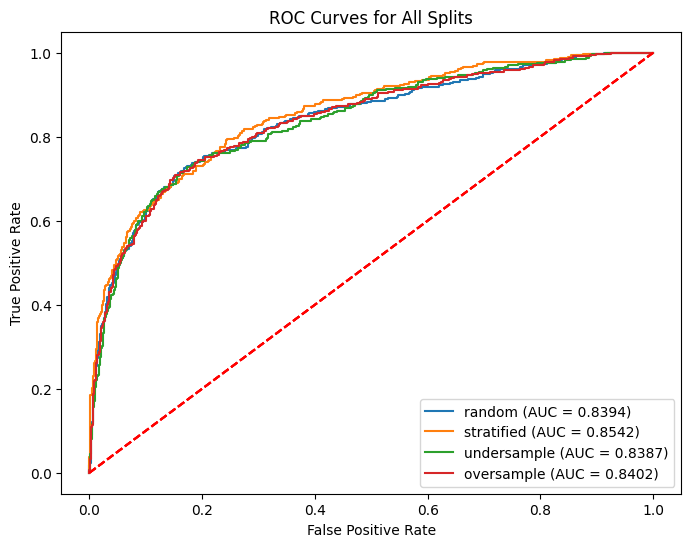

In [101]:
#Create a new model with the identified optimal parameters
best_parameters = random_search.best_params_
RS_score = random_search.best_score_


RS_model = RandomForestClassifier(**best_parameters, random_state = 6)
performance_RS = {}
performance_RS = evaluating_performance_diff_splits(feature_importances=[],model=RS_model,split_data=split_data,performance_matrix=performance_RS)

In [98]:
# Convert to DataFrame and display the results
performance_RS_df = pd.DataFrame(performance_RS).T
performance_RS_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.802395,0.401198,0.534930,334.0,0.841923,0.687566
stratified,0.814815,0.472393,0.598058,326.0,0.855939,0.722460
undersample,0.505112,0.739521,0.600243,334.0,0.838735,0.774184
oversample,0.591667,0.637725,0.613833,334.0,0.840246,0.760805


We see that this hyperparameter tuning has led to some improvements in recall and balanced_accuracy, which are the key metrics we want to optimise for a model concerned with customer churn data. The most significant improvement is seen in the oversamppled split where recall increased from 0.497006 to 0.637725, followed by the undersampled split having next best increasing from 0.724551 to 0.739521. These improvements in recall suggest that the optimized model is better at identifying positive instances (customers leaving), which is especially important since incorrectly identifying customers as retained when they've left is costly. This is confirmed in the confusion matrices. There is a noticeable improvement in balanced accuracy across most splits, particularly in undersampled, from 0.764329 to 0.774184 and oversampled, from 0.714933 to 0.760805. This indicates a more balanced performance between the churn and retained classes. Precison is seen to decrease in undersampled split, as expected with increasing recall, since increasing recall can increase false positives. The AUC values have shown minor improvements, with increases across most splits. Notably, in the random split the AUC improved from 0.832439 to 0.841923. However, the optimal parameters were found based on the random data split, so we can't put too much confidence in this. The changes are small, indicating that the model's overall ability to distinguish between the classes has remained relatively stable. 

## Feature Importance
Finally we look at feature importance and see how this affects our model

In [131]:
'''We use the train and test sets from the random split'''
X_train, X_val, y_train, y_val = split_data['random']


In [132]:
feature_list=list(X_train.columns)
# Get numerical feature importances
importances = list(RS_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Age                  Importance: 0.24
Variable: NumOfProducts        Importance: 0.19
Variable: CreditScoreGivenAge  Importance: 0.16
Variable: Balance              Importance: 0.09
Variable: CreditScore          Importance: 0.07
Variable: TenureByAge          Importance: 0.07
Variable: BalanceSalaryRatio   Importance: 0.06
Variable: IsActiveMember       Importance: 0.05
Variable: Geography_Germany    Importance: 0.04
Variable: Geography_France     Importance: 0.01
Variable: Geography_Spain      Importance: 0.01
Variable: Gender_Female        Importance: 0.01
Variable: Gender_Male          Importance: 0.01


[None, None, None, None, None, None, None, None, None, None, None, None, None]

Some variables have near zero importance so it seems like we should be able to get rid of some of them without impacting performance. First, let’s make a quick graph to represent the relative differences in feature importances. 

[0.06722773885427949, 0.2370342982435149, 0.08507439836673476, 0.18552336186933827, 0.06369017765026465, 0.07177610236412282, 0.15705939773393401, 0.05138276736091079, 0.01111654006373517, 0.039809659731253534, 0.007001051782694227, 0.011440370951203836, 0.011864135028013357]


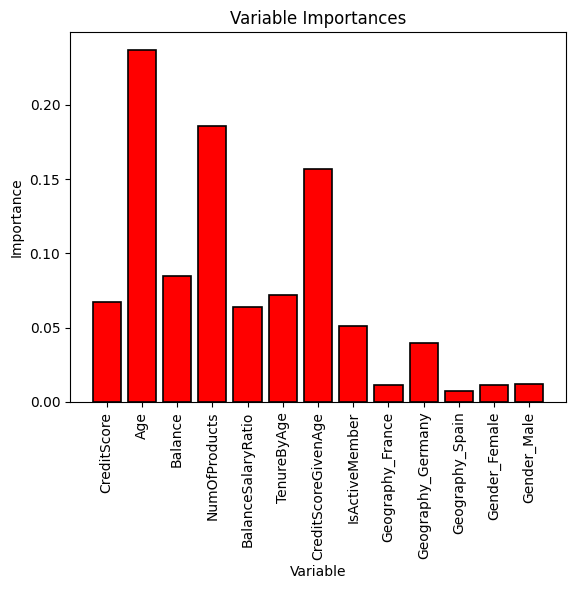

In [133]:
#List of feature locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

print(importances)

This depicts the relative differences in the feature importances. 

Text(0.5, 1.0, 'Cumulative Importances')

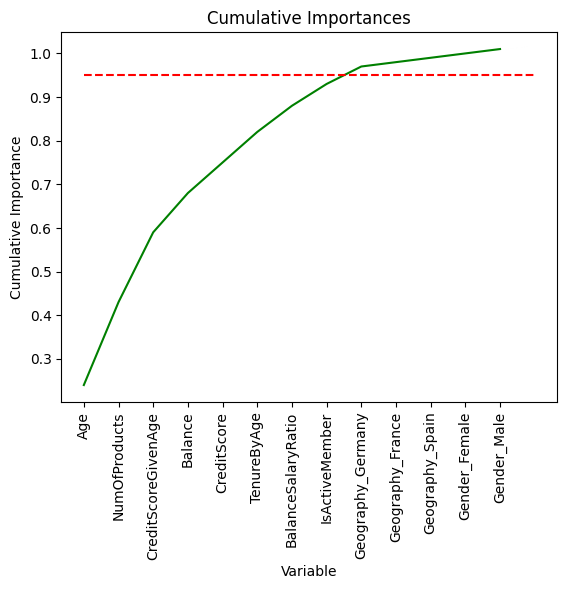

In [134]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

This is a gaphh of cumulative importance that shows the contribution to the overall importance of each variable. The dashed line is drawn at 95% of total importance accounted for which means the variables that lie above it can be disregarded and the model should perform at least the same or better. 95% is an arbitrary threshold, but if it leads to noticeably poor performance we can adjust the value. First, we need to find the exact number of features to exceed 95% importance:

In [135]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 9


We can then create a new training and testing set retaining only the 9 most important features.

In [150]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:9]]
print(important_feature_names)
# Create training and testing sets with only the important features
important_train_features = X_train[important_feature_names]
important_test_features = X_val[important_feature_names]


# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']
Important train features shape: (6400, 9)
Important test features shape: (1600, 9)


(6400,)

In [149]:
# Train the expanded model on only the important features
RS_model.fit(important_train_features, y_train)
# Make predictions on test data
predictions = RS_model.predict(important_test_features)

report = classification_report(y_val,predictions,output_dict=True)
report['1']


{'precision': 0.5942857142857143,
 'recall': 0.6227544910179641,
 'f1-score': 0.6081871345029239,
 'support': 334.0}

['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']
['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']
['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']
['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']


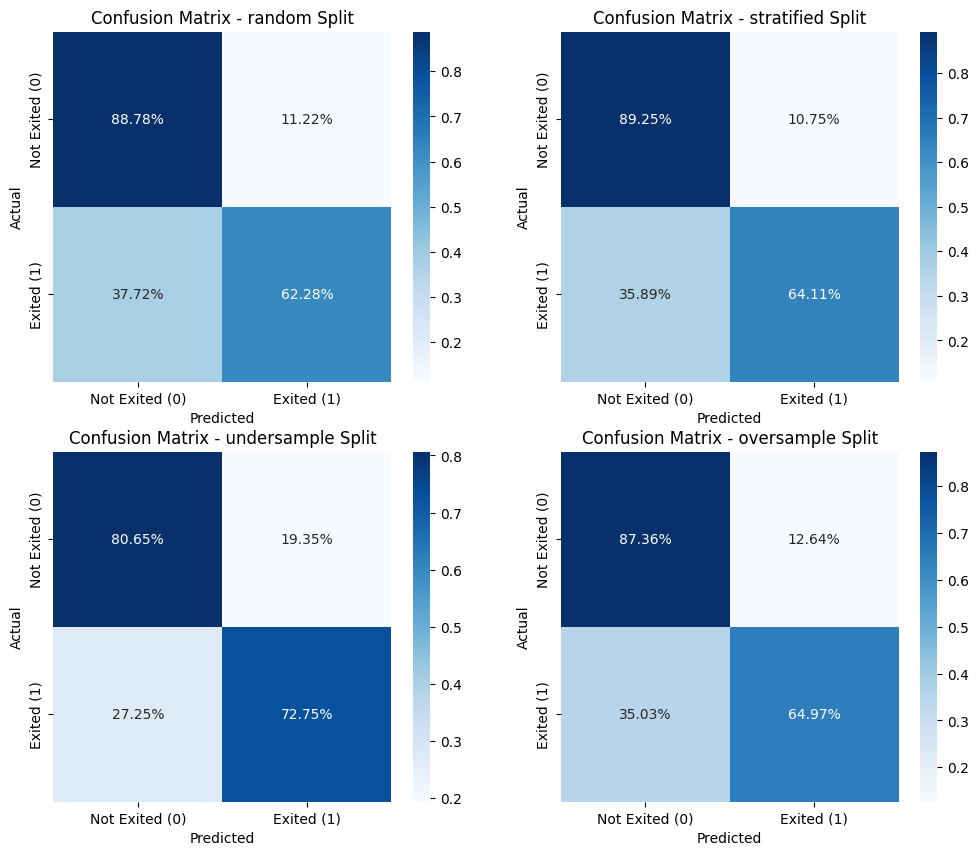

<Figure size 800x600 with 0 Axes>

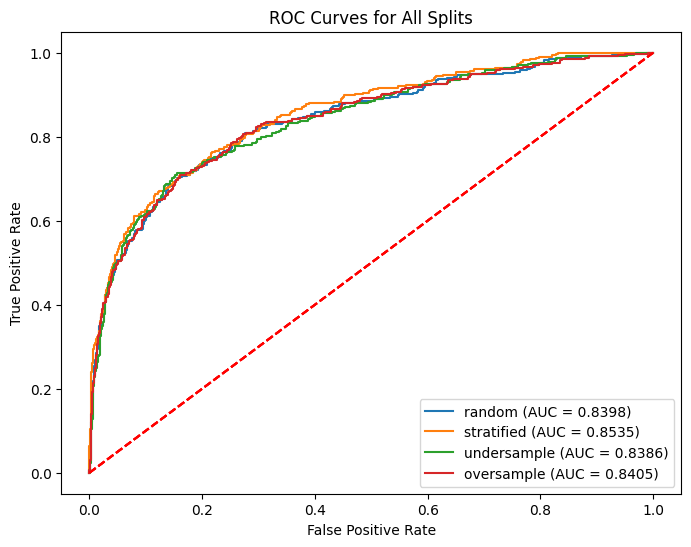

In [153]:
performance_fr = {}
performance_fr = evaluating_performance_diff_splits(feature_importances=feature_importances,model=RS_model,split_data=split_data,performance_matrix=performance_RS)

In [154]:
performance_fr =pd.DataFrame(performance_fr).T
performance_fr

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.594286,0.622754,0.608187,334.0,0.839794,0.755295
stratified,0.604046,0.641104,0.622024,326.0,0.853541,0.766784
undersample,0.497951,0.727545,0.591241,334.0,0.838614,0.767011
oversample,0.575597,0.649701,0.610408,334.0,0.840487,0.761659


Random and stratified sampling show significant improvements in recall and overall balanced accurace after feature reduction which helped remove noise/ irrelevant features, which improved the generalisation of the model, correctly predicting more churners. Undersamples split shows a slight reduction in recall and precision, indicating that removing features may have reduced its ability to balance predictions between the classes. Similarly, oversampled split shows a decline in precision but its overall performance remained stable. 

## Final Model
So now we have trained our model we will use it to predict on the unseen test data to see how well our model actually generalizes. I will also focus my attention on the stratified split since we have significantly improved the false negatives while maintaining a strong precision score.

['Age', 'NumOfProducts', 'CreditScoreGivenAge', 'Balance', 'CreditScore', 'TenureByAge', 'BalanceSalaryRatio', 'IsActiveMember', 'Geography_Germany']


AttributeError: 'numpy.ndarray' object has no attribute 'spines'

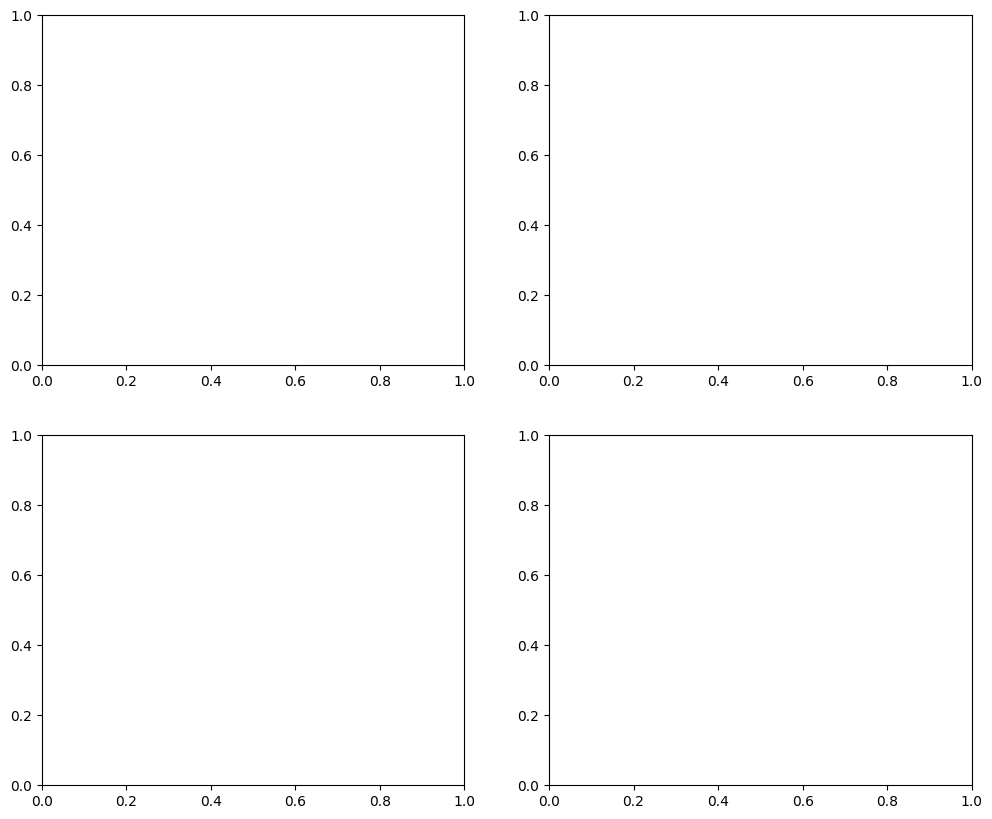

<Figure size 800x600 with 0 Axes>

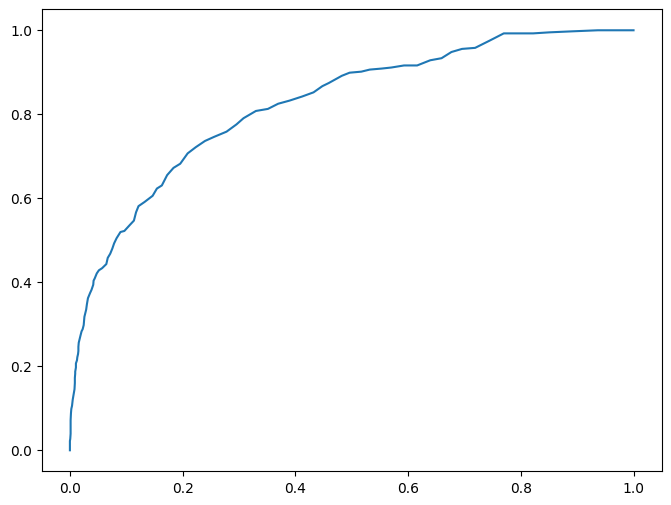

In [156]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score


#Store our performance results in a dictionary
performance = {}


#Create a 2x2 grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plt.figure(figsize=(8,6))

#ROC curve figure 
plt.figure(figsize=(8,6))

X_train, X_val, y_train, y_val = split_data['stratified']


important_feature_names = [feature[0] for feature in feature_importances[0:9]]
print(important_feature_names)
# Create training and testing sets with only the important features
X_train = X_train[important_feature_names]
X_test = X_test_raw[important_feature_names]



# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the unseen test set (X_test)
y_test_pred = model.predict(X_test)

# Get predicted probabilities for ROC curve on the test set
y_test_score = model.predict_proba(X_test)[:, 1]

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_raw, y_test_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Stratified Split (AUC = {roc_auc:.4f})')

# Plot confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with heatmap
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes,
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
axes.set_title(f'Confusion Matrix - Stratified Split')
axes.set_ylabel('Actual')
axes.set_xlabel('Predicted')

# Generate classification report
report = classification_report(y_test_raw, y_test_pred, output_dict=True)

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_test_raw, y_test_pred)

# Store performance metrics in the dictionary
performance['stratified'] = {
    'precision': report['1']['precision'],
    'recall': report['1']['recall'],
    'f1-score': report['1']['f1-score'],
    'support': report['1']['support'],
    'roc_auc': roc_auc,
    'balanced_accuracy': balanced_acc
}

# Finish ROC plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stratified Split')
plt.legend(loc='lower right')

# Show the plots
plt.show()

    

## References

- https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html